In [1]:
# ================================================================
# Deforestation Risk Map for Palangkara-West Kalimantan
# Landsat 4,5,8,9 
# ================================================================

# (If needed)
%pip install -q earthengine-api geemap pandas matplotlib ipywidgets

import ee, geemap, pandas as pd, numpy as np
import matplotlib.pyplot as plt
import geemap.foliumap as geemap
import ipywidgets as widgets
from ipywidgets import VBox, Layout
from ipywidgets import HBox, Layout
from IPython.display import display  


# --------------------------------------------
# Initialize Earth Engine
# --------------------------------------------
# ee.Authenticate()  # uncomment if you didn't authenticate yet
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()
print("Earth Engine initialized.")

Note: you may need to restart the kernel to use updated packages.
Earth Engine initialized.


In [2]:
#  ROI: Palangkara-West Kalimantan + year list ─────────────────────────────────────────
roi = ee.Geometry.Polygon([[[113.69001648196563, -1.8770593752211775],
          [113.69001648196563, -2.401289120996008],
          [114.19676086673125, -2.401289120996008],
          [114.19676086673125, -1.8770593752211775]]])

year_list = [1990, 2005, 2020]

# m = geemap.Map(center=[113.69001648196563, -2.401289120996008], zoom=6)
# m.addLayer(roi, {"color":"#2233ff"}, "Palangkara-West Kalimantan", True, 0.7)
# m


In [3]:
#  Landsat collections & cloud masks (C02/T1_L2) ───────────────────────────
l4 = ee.ImageCollection("LANDSAT/LT04/C02/T1_L2")
l5 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
l9 = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")

def filter_col(col, roi, date_range):
    start, end = date_range
    return col.filterDate(start, end).filterBounds(roi)

def cloud_mask_tm(image):
    qa = image.select("QA_PIXEL")
    dilated = 1 << 1
    cloud = 1 << 3
    shadow = 1 << 4
    mask = (qa.bitwiseAnd(dilated).eq(0)
            .And(qa.bitwiseAnd(cloud).eq(0))
            .And(qa.bitwiseAnd(shadow).eq(0)))
    return (image.select(["SR_B1","SR_B2","SR_B3","SR_B4","SR_B5","SR_B7"],
                         ["B2","B3","B4","B5","B6","B7"])
                  .updateMask(mask)
                  .multiply(0.0000275)
                  .add(-0.2))

def cloud_mask_oli(image):
    qa = image.select("QA_PIXEL")
    dilated = 1 << 1
    cirrus = 1 << 2
    cloud  = 1 << 3
    shadow = 1 << 4
    mask = (qa.bitwiseAnd(dilated).eq(0)
            .And(qa.bitwiseAnd(cirrus).eq(0))
            .And(qa.bitwiseAnd(cloud).eq(0))
            .And(qa.bitwiseAnd(shadow).eq(0)))
    return (image.select(["SR_B2","SR_B3","SR_B4","SR_B5","SR_B6","SR_B7"],
                         ["B2","B3","B4","B5","B6","B7"])
                  .updateMask(mask)
                  .multiply(0.0000275)
                  .add(-0.2))

def landsat457(roi, date_range):
    col = filter_col(l4, roi, date_range).merge(filter_col(l5, roi, date_range))
    return col.map(cloud_mask_tm).median().clip(roi)

def landsat89(roi, date_range):
    col = filter_col(l8, roi, date_range).merge(filter_col(l9, roi, date_range))
    return col.map(cloud_mask_oli).median().clip(roi)

In [4]:
# Build composites, VI, and forest masks ───────────────────────────────────
def make_year_image(year, roi):
    start = ee.Date.fromYMD(year - 1, 1, 1)
    end   = ee.Date.fromYMD(year + 1, 12, 31)
    date_range = [start, end]
    if year < 2014:
        img = landsat457(roi, date_range)
    else:
        img = landsat89(roi, date_range)
    band_map = {"NIR": img.select("B5"), "SWIR": img.select("B7")}
    vi = img.expression("(NIR - SWIR) / (NIR + SWIR)", band_map).rename("VI")
    forest = vi.gt(0.7).selfMask().rename("forest")
    return (img, vi, forest)

year_products = {}
for yr in year_list:
    img, vi, forest = make_year_image(yr, roi)
    year_products[yr] = {"image": img, "vi": vi, "forest": forest}

rgb_vis = {"min": [0.1, 0.05, 0], "max": [0.4, 0.3, 0.15], "bands": ["B5","B6","B2"]}
vi_vis  = {"min": -1, "max": 1, "palette": ["blue","white","green"]}

In [5]:
#  Interactive map with layers ─────────────────────────────────────────────
m = geemap.Map(center=[113.69001648196563, -2.401289120996008], zoom=6)
m.addLayer(roi, {"color": "black"}, "Palangkara-West Kalimantan", True, 0.7)

for yr in year_list:
    m.addLayer(year_products[yr]["image"], rgb_vis, f"SR_{yr}", False)
    m.addLayer(year_products[yr]["vi"], vi_vis, f"VI_{yr}", False)
    m.addLayer(year_products[yr]["forest"], {"palette": ["green"]}, f"Forest_{yr}", False)

# m.add_colorbar(vis_params=vi_vis, label="VI", layer_name=f"VI_{year_list[-1]}")
# m

In [6]:
#  Deforestation layers and forest areas ────────────────────────────────────
forest_1990 = year_products[1990]["forest"]
forest_2005 = year_products[2005]["forest"]
forest_2020 = year_products[2020]["forest"]

def_area_1990_2005 = forest_1990.eq(1).And(forest_2005.unmask(0).eq(0)).selfMask()
def_area_2005_2020 = forest_2005.eq(1).And(forest_2020.unmask(0).eq(0)).selfMask()

# m2 = geemap.Map(center=[113.69001648196563, -2.401289120996008], zoom=6)
# m2.addLayer(roi, {"color": "black"}, "Palangkara-West Kalimantan", True, 0.7)
# m2.addLayer(def_area_1990_2005, {"palette":["red"]}, "Deforestation 1990-2005", True)
# m2.addLayer(def_area_2005_2020, {"palette":["orange"]}, "Deforestation 2005-2020", True)
# m2.addLayer(forest_2020, {"palette":["green"]}, "Forest 2020", False)
# m2

In [7]:
# Compute forest area (ha) for 1990 and 2020 + deforestation areas
def area_ha(mask_img, geom):
    pix_area_ha = ee.Image.pixelArea().divide(10000)
    stats = pix_area_ha.updateMask(mask_img).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geom,
        scale=30,
        bestEffort=True
    )
    return ee.Number(stats.get('area')) if stats.get('area') else ee.Number(0)

areas = {}
for yr in year_list:
    a = area_ha(year_products[yr]["forest"], roi)
    areas[yr] = a

def1990_2005_ha = area_ha(def_area_1990_2005, roi)
def2005_2020_ha = area_ha(def_area_2005_2020, roi)

areas_client = {yr: areas[yr].getInfo() for yr in year_list}
def1990_2005_ha_client = def1990_2005_ha.getInfo()
def2005_2020_ha_client = def2005_2020_ha.getInfo()

display(areas_client, def1990_2005_ha_client, def2005_2020_ha_client)

{1990: 257533.24481078354, 2005: 196874.40339864252, 2020: 208405.82205061466}

73802.80536863973

30859.746029176655

In [8]:
# FAO deforestation rate q = ((A2/A1)^(1/(t2 - t1))) - 1
import math
A1 = areas_client[1990]
A2 = areas_client[2020]
T1, T2 = 1990, 2020
q = ( (A2 / A1) ** (1 / (T2 - T1)) ) - 1 if A1 and A2 else float('nan')
q


-0.007030554912139775

In [9]:
#  Risk map (meter-based focal; no reproject on display)
forest_raster = (ee.Image(0)
                 .where(def_area_1990_2005.eq(1), 1)
                 .where(def_area_2005_2020.eq(1), 2)
                 .where(forest_2020.eq(1), 3)
                 .selfMask()
                 .clip(roi))

def_rate = abs(q) if isinstance(q, (int, float)) and not math.isnan(q) else 0.0
array = ee.List.repeat(ee.List.repeat(def_rate, 9), 9)
kernel = ee.Kernel.fixed(9, 9, array)

risk = (forest_raster.convolve(kernel)
        .updateMask(forest_2020)
        .reproject("EPSG:4326", None, 30)
        .abs()
        .multiply(-1)
        .rename("risk"))

minmax = risk.reduceRegion(
    geometry=roi,
    scale=30,
    reducer=ee.Reducer.percentile([0.1, 99.9]),
    bestEffort=True
)
risk_min = ee.Number(minmax.get("risk_p0"))
risk_max = ee.Number(minmax.get("risk_p100"))

risk_eq = (risk.clamp(risk_min, risk_max)
               .unitScale(risk_min, risk_max)
               .multiply(30)
               .toByte())

palette = ["green","yellow","red","purple"]
# m3 = geemap.Map(center=[113.69001648196563, -2.401289120996008], zoom=6)
# m3.addLayer(roi, {"color":"black"}, "Palangkara-West Kalimantan ROI", True, 0.7)
# m3.addLayer(risk_eq, {"min": 0, "max": 30, "palette": palette}, "Risk Equal Interval", True)
# m3.add_colorbar(vis_params={"min":0,"max":30,"palette":palette}, label="Risk Class (0–30)", layer_name="Risk Equal Interval")
# m3

In [10]:
# Tabular summaries ───────────────────────────────────────────────────────
import pandas as pd
df_areas = pd.DataFrame({
    "Year": year_list,
    "Forest area (ha)": [areas_client[y] for y in year_list]
}).sort_values("Year")

df_defor = pd.DataFrame({
    "Period": ["1990–2005", "2005–2020"],
    "Deforestation area (ha)": [def1990_2005_ha_client, def2005_2020_ha_client]
})

print("Forest area by year (ha):")
display(df_areas)

print("Deforestation area by period (ha):")
display(df_defor)

print("FAO deforestation rate (annual, 1990–2020): {:.4%}".format(q) if not math.isnan(q) else "FAO deforestation rate: N/A")

Forest area by year (ha):


,Year,Forest area (ha)
0,1990,257533.244811
1,2005,196874.403399
2,2020,208405.822051


Deforestation area by period (ha):


,Period,Deforestation area (ha)
0,1990–2005,73802.805369
1,2005–2020,30859.746029


FAO deforestation rate (annual, 1990–2020): -0.7031%


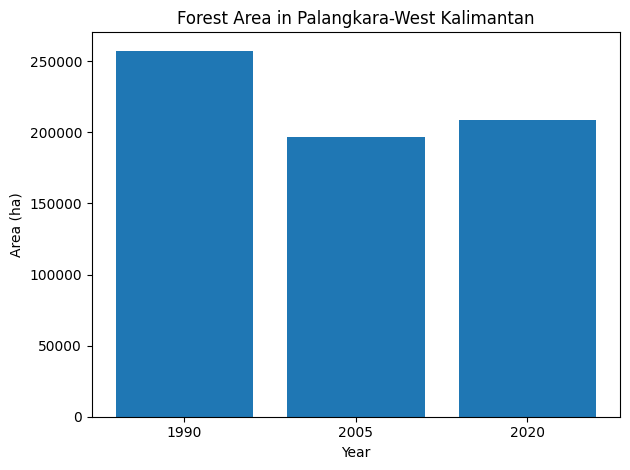

In [11]:
# Forest Area Chart ────────────────────────────────────────────────
plt.figure()
plt.bar(df_areas["Year"].astype(str), df_areas["Forest area (ha)"])
plt.title("Forest Area in Palangkara-West Kalimantan")
plt.xlabel("Year")
plt.ylabel("Area (ha)")
plt.tight_layout()
plt.show()


### Notes & Parameters
- **Collections:** Landsat Collection 2 Level-2 paths: `LT04`, `LT05`, `LC08`, `LC09` (T1_L2).  
- **Scaling:** SR bands scaled per Collection 2: `reflectance = DN*0.0000275 - 0.2`.  
- **VI threshold:** `VI > 0.7` as forest
- **Kernel for risk:** 9×9 kernel filled with the magnitude of the **annual deforestation rate**;  
- **Admin boundaries:** FAO GAUL 2015.  
